# Data processing stage


In [143]:
import csv
import numpy as np
import time
import json
import matplotlib.pylab as plt

In [78]:
def read_data(file_name):
    """ Reads a vocabulary from a .txt file into a list of strings
    
    Parameters
    ----------
    file_name : str
        a path to a vocabulary file
    
    Returns
    -------
    review : a list of raw strings
        a list of raw strings from a .csv file
    sentiment: a list of 1 and 0, where 1 is positive and 0 is negative sentiment
    """
    review = []
    sentiment = []
    
    # YOUR CODE HERE
    with open(file_name, newline='', encoding="utf8") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            review.append(row[0].replace('<br /><br />', ' '))
            review.append(row[0])
            if row[-1] == "positive":
                sentiment.append(1)
            else:
                sentiment.append(0)
                
    return review[1:], sentiment[1:]

In [79]:
# review, sentiment = read_data("toy_dataset.csv")
review, sentiment = read_data("IMDB Dataset.csv")
print(review[-1])
# print(sentiment[0])

No one expects the Star Trek movies to be high art, but the fans do expect a movie that is as good as some of the best episodes. Unfortunately, this movie had a muddled, implausible plot that just left me cringing - this is by far the worst of the nine (so far) movies. Even the chance to watch the well known characters interact in another movie can't save this movie - including the goofy scenes with Kirk, Spock and McCoy at Yosemite.<br /><br />I would say this movie is not worth a rental, and hardly worth watching, however for the True Fan who needs to see all the movies, renting this movie is about the only way you'll see it - even the cable channels avoid this movie.


## Basic Tokenization (NOT USED -- skip to next section)

Different tokenization schemes can lead to different results later on. Here we try two types of tokenization: 

(1) Regular expression tokenization where
- all alpha strings with one hyphen or apostrophe inside (i.e should be able to find "a-ha" or "it's", but not "hi--ppo" or "44.44")

(2) Penn Treebank tokenizer

### Stop words
We also remove stop words from our dataset.

In [8]:
# import re #regular expression usage

# # #Example of a regular expression tokenizer:
# # regex_tokenizer = re.compile("\w\w*[-'.]*\w\w*|\S\w*")

# def tokenize(data, tokenizer):
#     """ Reads a vocabulary from a .txt file into a list of strings
    
#     Parameters
#     ----------
#     data : str
#         a list of raw strings
#     tokenizer:
#         a regular expression re.compile() object
        
#     Returns
#     -------
#     tokenized_review : a list of lists - each raw string is tokenized 
#         and lowercased into a list using the tokenizer

#     """
#     tokenized_review = []
    
#     for review in data:
#         tokenized_review.append(re.findall(tokenizer, review.lower()))
    
#     return tokenized_review

In [9]:
# regex_tokenizer = re.compile("[a-z][a-z]*[-']?[a-z][a-z]*|[a-z]")

# tokenized_reviews = tokenize(review, regex_tokenizer)

## Normalization: Tokenization and Lemmatization

Here we tokenize and lemmatize our words into its stems with [Stanza](https://stanfordnlp.github.io/stanza/index.html).

Here are the steps given the name of a file:
1. read it
2. tokenize and lemmatize it
3. lowercase lemmas
4. remove lemmas that are present in a stop word list

In [8]:
!pip install -q stanza
import stanza
print("Downloading English model...")
stanza.download('en', verbose=False)

In [9]:
!pip install -U --user -q spacy
import spacy

In [10]:
import nltk
# import ssl
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
stop_words_english = stopwords.words('english')
print("Got stopwords")

Got stopwords


In [13]:
def tokenize_and_normalize(reviews, stopwords=None, tokenize_with_spacy=True, checkpoint_size=1000):
    """Tokenizes, lemmatizes, lowercases and removes stop words if specified
    
    this function takes in a path to a song, reads the song file,
    tokenizes it into words, then lemmatizes and lowercases these words.
    finally, stopwords given to the function are removed from the list of song lemmas
    
    Parameters
    ----------
    file_name : str
        a path to a text file
    stopwords : (optional) list of strings
        stopwords that should be removed
    
    Returns
    -------
    normalized_song : list of strings
        a song represented as a list of its lemmas
    """
    # create stanza Pipeline object: first tokenize, then lemmatize
#     nlp = stanza.Pipeline(lang='en', processors='tokenize, lemma',  verbose=False)
    
#     song = open(file_name, 'r').read();
#     song_doc = nlp(song);
#     normalized_song = []
    
#     for i, sent in enumerate(song_doc.sentences):
#         for word in sent.words:
#             lem = word.lemma.lower()
#             if lem not in stopwords:
#                 normalized_song.append(lem)

    stopword_filter = lambda word : True if stopwords==None else word in stopwords 
    nlp = stanza.Pipeline(lang='en', processors='tokenize,lemma',  verbose=False, tokenize_no_ssplit=True, tokenize_with_spacy=tokenize_with_spacy)
    print('Pipeline made')
    start_time = time.time() # log the time
    
    reviews_lemmatized = []
    reviews_lemmatized_checkpoint = []
    count = 0
    
    for review in reviews:
        count+=1
        review = nlp(review)
        temp = []
        for sent in review.sentences:
            for word in sent.words:
                # sometimes there is an error here, so have a try except
                try: 
                    lemma_lowered = word.lemma.lower()
                    if stopword_filter(lemma_lowered):
                        temp.append(lemma_lowered)
                except:
                    print(f"Couldn't add {word.text} to lemmatized review. Skip!")
        reviews_lemmatized_checkpoint.append(temp)

        if count%checkpoint_size == 0:
            pathname = "dataset_lemmatized/dataset_lemmatized_checkpoint_" + str(count).zfill(5) + ".json"
            print("writing checkpoint into: " + pathname)
            with open(pathname, 'w') as f:
                json.dump(reviews_lemmatized_checkpoint, f)
            reviews_lemmatized += reviews_lemmatized_checkpoint
            reviews_lemmatized_checkpoint = []
        
    reviews_lemmatized += reviews_lemmatized_checkpoint
    print(f'Done. Time elapsed: {time.time()-start_time}')

    with open("dataset_lemmatized/dataset_lemmatized.json", 'w') as f:
        json.dump(reviews_lemmatized, f)

    # return reviews_lemmatized

In [14]:
# tokenize_and_normalize(reviews, stop_words_english)
tokenize_and_normalize(review)

Pipeline made
Couldn't add wookie to lemmatized review. Skip!
writing checkpoint into: dataset_lemmatized/dataset_lemmatized_checkpoint_11000.json
writing checkpoint into: dataset_lemmatized/dataset_lemmatized_checkpoint_12000.json
writing checkpoint into: dataset_lemmatized/dataset_lemmatized_checkpoint_13000.json
writing checkpoint into: dataset_lemmatized/dataset_lemmatized_checkpoint_14000.json
writing checkpoint into: dataset_lemmatized/dataset_lemmatized_checkpoint_15000.json
writing checkpoint into: dataset_lemmatized/dataset_lemmatized_checkpoint_16000.json
writing checkpoint into: dataset_lemmatized/dataset_lemmatized_checkpoint_17000.json
writing checkpoint into: dataset_lemmatized/dataset_lemmatized_checkpoint_18000.json
writing checkpoint into: dataset_lemmatized/dataset_lemmatized_checkpoint_19000.json
writing checkpoint into: dataset_lemmatized/dataset_lemmatized_checkpoint_20000.json
writing checkpoint into: dataset_lemmatized/dataset_lemmatized_checkpoint_21000.json
wri

In [169]:
# # # DO NOT USE!!! Reading the .json dataset
# reviews_lemmatized = []
# for count in range(1000, 51000, 1000):
#     pathname = "dataset_lemmatized/dataset_lemmatized_checkpoint_" + str(count).zfill(5) + ".json"
#     with open(pathname, 'r') as f:
#         reviews_lemmatized = reviews_lemmatized + json.load(f)
        
# # np.size(reviews_lemmatized)
# with open("dataset_lemmatized/dataset_lemmatized.json", 'w') as f:
#     json.dump(reviews_lemmatized, f)

## Normalization - removing non-alphabetical lemmas using regular expressions

In [31]:
# remove lemmas that contain non-word chars
import re
regex_alpha = re.compile('\A[a-z]+\Z')
reviews_normalized = [[word for word in review if regex_alpha.match(word)!=None] for review in reviews_lemmatized]

In [60]:
# remove lemmas that contain non-word chars
with open("dataset_lemmatized/dataset_normalized.json", 'w') as f:
     json.dump(reviews_normalized, f)

#### Stopwords English - nltk
Remove english stopwords from nltk

In [158]:
from nltk.corpus import stopwords
stop_words_english = stopwords.words('english')

reviews_normalized_NLTKstopword = [[word for word in review if word not in stop_words_english] for review in reviews_normalized]
with open("dataset_lemmatized/dataset_normalized_NLTKstopword.json", 'w') as f:
     json.dump(reviews_normalized_NLTKstopword, f)

In [161]:
reviews_normalized_NLTKstopword[0]

#### Stopwords Method TF1 - singleton words removal for decreasing sparsity
Implemented TF1 stopwords removal from normalized reviews from cell above, where words that only appear once in the corpus are removed. Improves sparsity and accuracy.

Saif et al. "On Stopwords, Filtering and Data Sparsity for Sentiment Analysis of Twitter" http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf

In [ ]:
from collections import Counter

In [164]:
reviews_vocab = Counter(np.concatenate(reviews_normalized))

In [165]:
def slim_dictionary_TF1(counter):
    counter.subtract(counter.keys())
    return +counter

reviews_vocab_TF1 = slim_dictionary_TF1(reviews_vocab)
print(f'Original vocabulary size: {len(reviews_vocab.keys())} \nVocabulary size with singletons removed: {len(reviews_vocab_TF1.keys())}') 

In [56]:
### remove only TF1 stopwords
reviews_normalized_TF1 = [[word for word in review if word in reviews_vocab_TF1] for review in reviews_normalized]
with open("dataset_lemmatized/dataset_normalized_TF1stopword.json", 'w') as f:
     json.dump(reviews_normalized_TF1, f)

Stopwords TF1 + NLTK

In [167]:
### remove both TF1 and NLTK stopwords
reviews_normalized_NLTKTF1 = [[word for word in review if word in reviews_vocab_TF1] for review in reviews_normalized_NLTKstopword]
with open("dataset_lemmatized/dataset_normalized_NLTK+TF1stopword.json", 'w') as f:
     json.dump(reviews_normalized_NLTKTF1, f)

#### Stopwords Method Mutual Information - removal words from vocab with low mutual information
Implemented Mutual Information MI stopwords removal from normalized reviews, where words have low mutual information score, meaning the word is not correlated with sentiment. Use the elbow method to determine cutoff for stopwords ordered by informativeness. -> See paper on informative score I

In [72]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [148]:
def calculate_MI_score(train_x, train_y, word_freq_cutoff=1):
    """ 
    takes in a training set of normalized reviews and associated ground truth labels, 
    calculates mutual information score for the words in the train vocab
    """
    train_vocab = Counter(np.concatenate(train_x))
    keys = list(np.repeat(list(train_vocab.keys()),word_freq_cutoff))
    train_vocab.subtract(keys)
    train_vocab_trimmed = +train_vocab
    print(f'Original vocabulary size: {len(train_vocab.keys())} \nVocabulary size with infrequent words removed: {len(train_vocab_trimmed.keys())}') 
    
    MI = dict()
    for word in train_vocab_trimmed.keys():
        MI[word] = normalized_mutual_info_score([bool(word in x) for x in train_x], train_y)
    
    # # plotting
    # x,mi_score = zip(*sorted(MI.items(), key=lambda item: item[1], reverse=True))
    # plt.plot(x,mi_score)
    # plt.show()
    
    return MI

In [141]:
# train_x = reviews_normalized[0:4]
word = ["violence"]
# y
# print()
# np.array(sentiment[0:100])
# np.shape(reviews_normalized[0:100])
np.repeat(word, 2)

array(['violence', 'violence'], dtype='<U8')

In [149]:
train_mi = calculate_MI_score(reviews_normalized[0:10000], sentiment[0:10000])

Original vocabulary size: 42010 
Vocabulary size with singletons removed: 25800


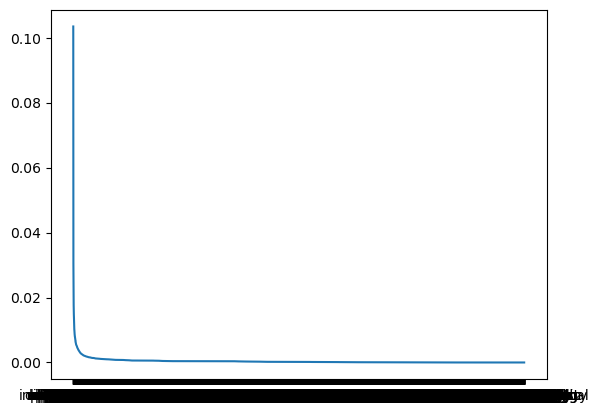

In [150]:
x,mi_score = zip(*sorted(train_mi.items(), key=lambda item: item[1], reverse=True))
plt.plot(x,mi_score)
plt.show()